In [205]:
%matplotlib inline

import notebook
import numpy as np
from astropy.time import Time
from astropy.io import fits
import glob
import itertools
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sns
import os
from scipy.optimize import curve_fit
import sys
from astropy import wcs 
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from matplotlib.patches import Circle
import gloess_fits as gf
sys.path.append('/Users/vs/Dropbox/Python')

bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [439]:
#input_target = sys.argv[1]
#input_channel = sys.argv[2]
#catalog = sys.argv[3]

input_target = 'omegaCen_3'
input_channel = '4p5um'
catalog = '/Users/vs/Dropbox/Publications/omegaCen/calibrated_files/kaluzny_catalogues/kaluzny2004_reformatted'
ref_image = input_target + '_e1_' + input_channel + '_dn.fits'

In [440]:
if (input_channel == '1' or input_channel == '3p6um'):
    channel = '3p6um'
if (input_channel =='2' or input_channel == '4p5um'):
    channel = '4p5um'
    
field = input_target[-1]
#print field, channel


In [441]:
#### Comment out this cell if not running on Vicky's computer

path = '/Volumes/Khaleesi/CRRP/Globular_Cluster_Output/omegaCen/'+ input_target +'_'+ channel + '/' + input_target + '_e*_' + channel + '_dn.fits'
input_image_list = glob.glob(path)
input_lc_data = '/Volumes/Khaleesi/CRRP/Globular_Cluster_Output/omegaCen/'+ input_target +'_'+ channel + '/'  + input_target + '_' + channel + '.cal'

mjds = np.zeros(len(input_image_list))

## Commenting this out for now - using a list of MJDS rather than reading them from headers.

for count in range(0, len(input_image_list)):
    hdulist = fits.open(input_image_list[count])
    prihdr = hdulist[0].header
    date_obs = Time(prihdr['date_obs'])
    mjds[count] = date_obs.mjd

In [4]:
#### Uncomment this cell if not running on Vicky's computer

## Get the mjds from these files - only applicable to omega cen data

#mjd_file = input_target + '_' + channel + '.mjds'
#epoch_num, mjds = np.loadtxt(mjd_file, unpack=True)
#input_lc_data = input_target + '_' + channel + '.cal'


In [442]:
if ((len(mjds) % 6 ) == 0):
    n_lines_raw = int((len(mjds) / 6) + 1)
else:
    n_lines_raw = int(np.ceil(len(mjds)) / 6 + 1)

with open(input_lc_data) as input:
    lines = []
    while True:
        line = list(itertools.islice(input, n_lines_raw))
        if line:
            lines.append(line)
        else:
            break


num_stars = len(lines)
num_frames = len(mjds)
objects = np.zeros((num_stars, (num_frames*2) + 3))
for star in np.arange(0,num_stars):
    data = "".join(lines[star])
    data = data.split()
    objects[star][0] = data[0] ## ID
    objects[star][1] = data[1] ## XC
    objects[star][2] = data[2] ## YC
    for epoch in np.arange(0,(num_frames*2), 2):
        objects[star][epoch + 3]  = data[epoch + 3] ## mag
        objects[star][epoch + 4] = data[epoch + 4] ## err
        

In [443]:
cols = ['als_id', 'xc', 'yc'] 

for epochs in np.arange(len(mjds)):
    mag_name = ('mag_' + str(epochs+1))
    err_name = ('err_' + str(epochs+1))
    cols.append(mag_name)
    cols.append(err_name)

cols

input_lc_df = pd.DataFrame(objects, columns=cols)
kaluzny = pd.read_csv(catalog, delim_whitespace=True, header=None, names=('ID', 'RA', 'Dec', 'Period', 'Vmag', 'Type'))

In [444]:
input_lc_df

,als_id,xc,yc,mag_1,err_1,mag_2,err_2,mag_3,err_3,mag_4,...,mag_8,err_8,mag_9,err_9,mag_10,err_10,mag_11,err_11,mag_12,err_12
0,17645.0,946.638,25.300,16.324,0.097,16.030,0.092,15.669,0.084,15.858,...,16.203,0.087,16.124,0.084,16.118,0.081,16.061,0.092,16.057,0.096
1,17205.0,927.675,25.378,17.060,0.130,17.383,0.179,16.993,0.149,17.041,...,16.730,0.131,16.711,0.111,16.842,0.120,16.688,0.134,16.880,0.106
2,17353.0,934.041,25.486,16.287,0.117,16.347,0.099,16.113,0.075,16.217,...,16.225,0.123,16.053,0.097,16.154,0.113,16.137,0.092,16.139,0.102
3,18661.0,1014.054,25.702,16.848,0.070,16.842,0.084,16.640,0.077,16.501,...,16.625,0.087,16.978,0.098,16.884,0.092,16.780,0.068,16.690,0.050
4,20051.0,1100.878,25.776,16.887,0.099,16.868,0.106,16.962,0.114,16.648,...,16.911,0.073,17.129,0.110,16.994,0.089,16.816,0.094,16.932,0.083
5,16616.0,889.281,26.395,15.174,0.072,15.152,0.092,15.276,0.077,15.355,...,15.205,0.104,15.222,0.101,15.272,0.097,15.236,0.092,15.161,0.094
6,16873.0,904.781,26.632,17.257,0.099,17.183,0.117,17.606,0.205,17.817,...,17.890,0.202,17.861,0.171,17.188,0.116,17.865,0.313,17.390,0.201
7,19914.0,1092.273,26.862,17.695,0.142,17.305,0.128,17.424,0.101,17.204,...,17.784,0.117,17.376,0.112,17.245,0.105,17.596,0.127,17.414,0.152
8,21473.0,1211.814,27.227,16.868,0.127,16.994,0.149,16.936,0.141,16.582,...,16.859,0.138,16.836,0.153,16.888,0.112,16.751,0.156,16.754,0.114
9,22156.0,1262.384,28.312,14.080,0.083,14.206,0.091,14.139,0.107,14.637,...,14.098,0.083,14.102,0.085,14.040,0.075,14.043,0.089,14.077,0.090


In [445]:
kaluzny

,ID,RA,Dec,Period,Vmag,Type
0,V3,13:25:56.15,-47:25:53.8,0.841258,14.01,RR0
1,V4,13:26:12.93,-47:24:18.8,0.627320,13.83,RR0
2,V5,13:26:18.33,-47:23:12.4,0.515274,14.00,RR0
3,V7,13:27:00.90,-47:14:00.5,0.713000,14.08,RR0
4,V8,13:27:48.45,-47:28:20.3,0.521329,13.90,RR0
5,V9,13:25:59.58,-47:26:24.0,0.523480,14.10,RR0
6,V10,13:26:06.99,-47:24:36.6,0.374976,14.31,RR1
7,V11,13:26:30.59,-47:23:01.6,0.564789,14.20,RR0
8,V12,13:26:27.21,-47:24:06.2,0.386769,14.32,RR1
9,V13,13:25:58.18,-47:25:21.6,0.669039,13.92,RR0


In [446]:
hdulist = fits.open(ref_image)
w = wcs.WCS(hdulist[0].header)
coords = SkyCoord(ra=kaluzny.RA, dec=kaluzny.Dec, frame='icrs', unit=(u.hour, u.deg))
kaluzny['xc'], kaluzny['yc'] = wcs.utils.skycoord_to_pixel(coords, w, 0, 'all')
image_range = hdulist[0].data.shape
hdulist.close()

image_limit_x = image_range[1]
image_limit_y = image_range[0]

In [447]:
image_range

(691, 1408)

In [448]:
als_file = input_target + '_e1_' + channel + '_dn.cal'
als_df = pd.read_csv(als_file, delim_whitespace=True, header=None, names=('als_id', 'xc', 'yc', 'mag', 'err', 'lcorr'))

In [449]:
als_df

,als_id,xc,yc,mag,err,lcorr
0,178,29.06,180.94,12.041,0.064,1.016
1,6184,362.62,98.83,15.965,0.186,1.013
2,18090,975.47,351.40,20.003,0.498,1.020
3,22472,1293.19,565.80,17.092,0.072,0.922
4,8762,500.80,57.52,16.490,0.099,0.993
5,3753,231.29,75.04,11.257,0.050,1.013
6,1210,92.73,200.06,14.496,0.097,1.015
7,19907,1093.86,282.59,17.264,0.057,1.014
8,22532,1300.40,552.20,16.820,0.068,0.922
9,4751,288.83,51.35,14.247,0.101,1.012


In [450]:
matched = np.ones(len(kaluzny))*-1
matched

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [451]:
### Brute force matching because daomaster hates me.
### Putting a hard limit on selecting matches within 10 pixles
curr_dir = os.getcwd().split('/')[-1]
new_dir = input_target + '_' + channel + '_plots'
is_there = os.path.exists(new_dir)
if (curr_dir != new_dir):
    if (is_there == False):
        os.mkdir(new_dir)

## Search for the matches

matched = np.ones(len(kaluzny))*-1
good_distance = np.ones(len(kaluzny))*-1

for rrl in np.arange(len(kaluzny)):
    best_distance = 100
    for test_star in np.arange(len(als_df)):
        if (kaluzny.xc[rrl] < image_limit_x and kaluzny.xc[rrl] > 0 and kaluzny.yc[rrl] < image_limit_y and kaluzny.yc[rrl] > 0):
            x_distance = kaluzny.xc[rrl] - als_df.xc[test_star]
            y_distance = kaluzny.yc[rrl] - als_df.yc[test_star]
            distance = np.sqrt(x_distance**2 + y_distance**2)
            if distance < best_distance:
                best_distance = distance
                best_match = test_star
    if best_distance < 10:
        matched[rrl] = als_df.als_id[best_match]
        good_distance[rrl] = best_distance
    best_distance = 100
        

In [452]:
## converting the matched and good_distance lists to data frames for combining with the kaluzny data frame

matched_df = pd.DataFrame(matched)
distance_df = pd.DataFrame(good_distance)

In [453]:
### als_id = -1 means it didn't match with the required limits
### distance is the distance in pixels between the predicted pixel position from the kaluzny catalogue and the observed position
## 1 pixel = 0.6 arcsec
kaluzny['als_id'] = matched_df
kaluzny['distance'] = distance_df

In [454]:
kaluzny

,ID,RA,Dec,Period,Vmag,Type,xc,yc,als_id,distance
0,V3,13:25:56.15,-47:25:53.8,0.841258,14.01,RR0,254.940663,1053.031789,-1.0,-1.000000
1,V4,13:26:12.93,-47:24:18.8,0.627320,13.83,RR0,-56.382072,959.676736,-1.0,-1.000000
2,V5,13:26:18.33,-47:23:12.4,0.515274,14.00,RR0,-199.444965,971.116652,-1.0,-1.000000
3,V7,13:27:00.90,-47:14:00.5,0.713000,14.08,RR0,-1362.281292,1091.975056,-1.0,-1.000000
4,V8,13:27:48.45,-47:28:20.3,0.521329,13.90,RR0,-888.400042,-482.033419,-1.0,-1.000000
5,V9,13:25:59.58,-47:26:24.0,0.523480,14.10,RR0,250.621089,976.357730,-1.0,-1.000000
6,V10,13:26:06.99,-47:24:36.6,0.374976,14.31,RR1,34.895376,1011.142506,-1.0,-1.000000
7,V11,13:26:30.59,-47:23:01.6,0.564789,14.20,RR0,-356.769966,834.601574,-1.0,-1.000000
8,V12,13:26:27.21,-47:24:06.2,0.386769,14.32,RR1,-239.632074,800.795942,-1.0,-1.000000
9,V13,13:25:58.18,-47:25:21.6,0.669039,13.92,RR0,192.526081,1065.807311,-1.0,-1.000000


In [455]:
### Total number of RRL matched in this field/channel combo
sum(kaluzny.als_id>0)

29

In [456]:
## Setting up the output file name
outfile = input_target + '_' + channel + '_rrl' + '_matched_to_kaluzny.cal'
print outfile


omegaCen_3_4p5um_rrl_matched_to_kaluzny.cal


In [457]:
## matching the data frames on als_id

huge_df = als_df.merge(kaluzny, on='als_id')
huge_df.rename(columns={'xc_y':'xc_kal', 'yc_y': 'yc_kal'}, inplace=True)
huge_df.rename(columns={'xc_x':'xc', 'yc_x': 'yc'}, inplace=True)

In [458]:
huge_df

,als_id,xc,yc,mag,err,lcorr,ID,RA,Dec,Period,Vmag,Type,xc_kal,yc_kal,distance
0,6946,406.91,216.59,13.320,0.068,1.016,V120,13:26:25.52,-47:32:48.6,0.548537,14.20,RR0,405.606432,215.545195,1.670601
1,1163,89.55,523.95,13.180,0.096,1.003,V25,13:26:25.52,-47:28:23.3,0.588364,13.93,RR0,88.028084,523.194558,1.699094
2,2255,147.05,370.54,13.685,0.099,1.019,NV339,13:26:29.67,-47:29:51.8,0.301322,14.44,RR1,145.202125,370.217121,1.875871
3,11972,648.21,412.68,12.982,0.077,0.970,V34,13:26:07.21,-47:33:10.4,0.733967,14.05,RR0,646.764083,412.049853,1.577264
4,20937,1165.79,86.82,13.499,0.044,0.997,V14,13:25:59.74,-47:39:09.6,0.377114,14.29,RR1,1163.970811,85.338713,2.345988
5,10332,571.38,130.22,14.055,0.054,0.986,V44,13:26:22.39,-47:34:35.3,0.567545,14.17,RR0,570.063660,129.723849,1.406739
6,1727,121.07,431.26,8.872,0.062,1.014,V135,13:26:28.14,-47:29:17.6,0.632579,14.03,RR0,122.234519,428.434802,3.055790
7,20230,1113.17,237.07,13.262,0.035,1.012,V56,13:25:55.53,-47:37:44.1,0.568023,14.30,RR0,1111.188393,235.499482,2.528496
8,1932,128.66,378.92,13.917,0.072,1.017,V131,13:26:30.07,-47:29:40.7,0.392252,14.29,RR1,127.211998,378.232146,1.603076
9,4485,271.59,369.22,13.918,0.074,1.021,V40,13:26:24.56,-47:30:46.2,0.634072,13.88,RR0,270.366148,369.125976,1.227458


In [459]:
## Print to file
huge_df.to_csv(outfile, sep='\t', header=True, index=False)

In [460]:
### Now can I match the lc data frame to the kaluzny file too??

huge_df = huge_df.merge(input_lc_df, on='als_id')
#huge_df = huge_df.drop(['xc_y', 'yc_y'], 1)
huge_df = huge_df.rename(columns={'xc_y':'xc_lc', 'yc_y': 'yc_lc'})
huge_df = huge_df.rename(columns={'xc_x':'xc_ref', 'yc_x': 'yc_ref'})


In [461]:
### YES. YES I CAN.
huge_df

,als_id,xc_ref,yc_ref,mag,err,lcorr,ID,RA,Dec,Period,...,mag_8,err_8,mag_9,err_9,mag_10,err_10,mag_11,err_11,mag_12,err_12
0,6946,406.91,216.59,13.320,0.068,1.016,V120,13:26:25.52,-47:32:48.6,0.548537,...,13.180,0.053,13.225,0.077,13.154,0.075,13.123,0.083,13.143,0.078
1,1163,89.55,523.95,13.180,0.096,1.003,V25,13:26:25.52,-47:28:23.3,0.588364,...,13.121,0.088,13.173,0.080,13.335,0.093,13.384,0.086,13.253,0.104
2,2255,147.05,370.54,13.685,0.099,1.019,NV339,13:26:29.67,-47:29:51.8,0.301322,...,13.614,0.074,13.438,0.075,13.659,0.115,13.974,0.133,13.757,0.127
3,11972,648.21,412.68,12.982,0.077,0.970,V34,13:26:07.21,-47:33:10.4,0.733967,...,13.171,0.080,13.235,0.073,13.175,0.086,12.928,0.069,12.862,0.070
4,20937,1165.79,86.82,13.499,0.044,0.997,V14,13:25:59.74,-47:39:09.6,0.377114,...,13.378,0.040,13.411,0.037,13.455,0.035,13.486,0.033,13.375,0.029
5,10332,571.38,130.22,14.055,0.054,0.986,V44,13:26:22.39,-47:34:35.3,0.567545,...,13.751,0.069,13.787,0.053,13.854,0.056,13.956,0.062,13.901,0.075
6,20230,1113.17,237.07,13.262,0.035,1.012,V56,13:25:55.53,-47:37:44.1,0.568023,...,13.557,0.025,13.454,0.036,13.334,0.039,13.323,0.029,13.334,0.030
7,1932,128.66,378.92,13.917,0.072,1.017,V131,13:26:30.07,-47:29:40.7,0.392252,...,13.731,0.056,13.840,0.070,13.870,0.091,13.853,0.068,13.967,0.079
8,4485,271.59,369.22,13.918,0.074,1.021,V40,13:26:24.56,-47:30:46.2,0.634072,...,13.584,0.066,13.628,0.081,13.755,0.120,13.661,0.057,13.624,0.058
9,18202,982.67,75.40,13.164,0.025,1.016,V49,13:26:07.78,-47:37:55.5,0.604627,...,13.256,0.033,13.364,0.054,13.262,0.056,13.251,0.049,13.247,0.045


In [462]:
curr_dir = os.getcwd().split('/')[-1]
new_dir = input_target + '_' + channel + '_plots'
is_there = os.path.exists(new_dir)
if (curr_dir != new_dir):
    if (is_there == False):
        os.mkdir(new_dir)

### Now making the lightcurves should be a piece of piss. Right??

## Grab the corresponding mag data, and plot away...
lc_mag_columns = []
lc_err_columns = []
for epochs in np.arange(len(mjds)):
    mag_name = ('mag_' + str(epochs+1))
    err_name = ('err_' + str(epochs+1))
    lc_mag_columns.append(mag_name)
    lc_err_columns.append(err_name)

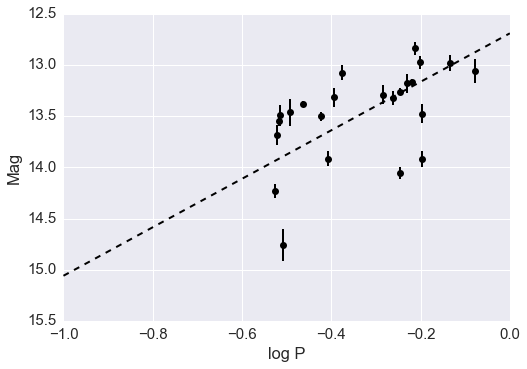

In [463]:

### Doing some quality checks on the matching
mp.close()
mp.clf()
axp1 = mp.subplot(111)

lp1 = np.arange(-1., 1, 1)
def pl1(logp, zp):
    return -2.355 * logp + zp

huge_df['logP'] = np.log10(huge_df.Period)
#huge_df.logP[np.where(huge_df['Type']=='RR1')] = np.log10(huge_df.Period) + 0.127

#huge_df['logP'][np.where(huge_df['Type']=='RR1')] = huge_df['logP'] + 0.127

popt, pcov = curve_fit(pl1,huge_df.logP,huge_df.mag)
zp = popt[0]
ezp = np.sqrt(float(pcov[0]))

mp.gca().invert_yaxis()
mp.xlabel('log P')
mp.ylabel('Mag')
axp1.errorbar(huge_df.logP, huge_df.mag, yerr=huge_df.err, color='k', ls='none')
axp1.plot(huge_df.logP, huge_df.mag, 'ko')
axp1.plot(lp1, -2.370*lp1 + zp, 'k--')


In [464]:
#### now reject some shit

## first rejecting on obviously bad matches

huge_df['reject'] = False
hdu_list = fits.open(ref_image)
image_data = hdu_list[0].data
hdu_list.close()

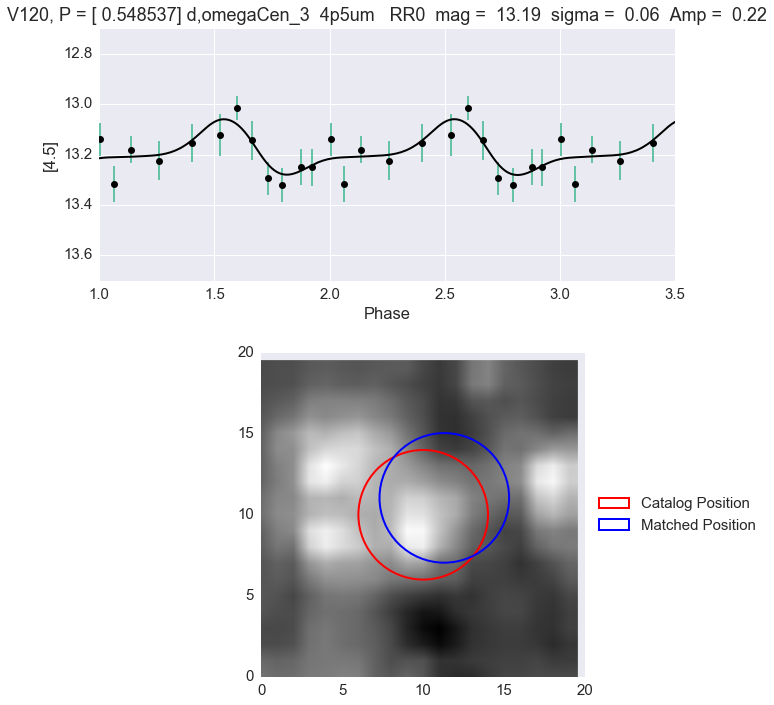

Is this a good star?
Answer yes or no: y


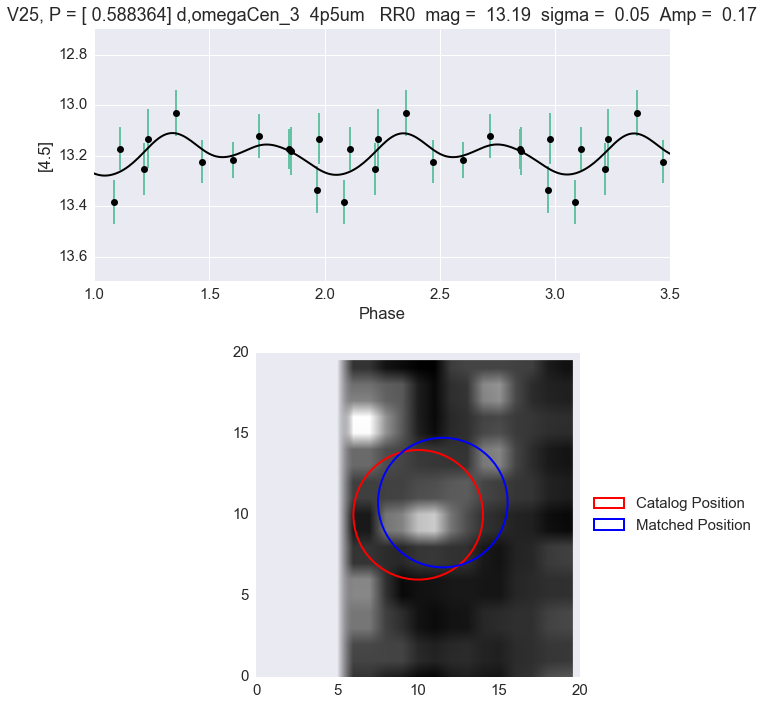

Is this a good star?
Answer yes or no: y


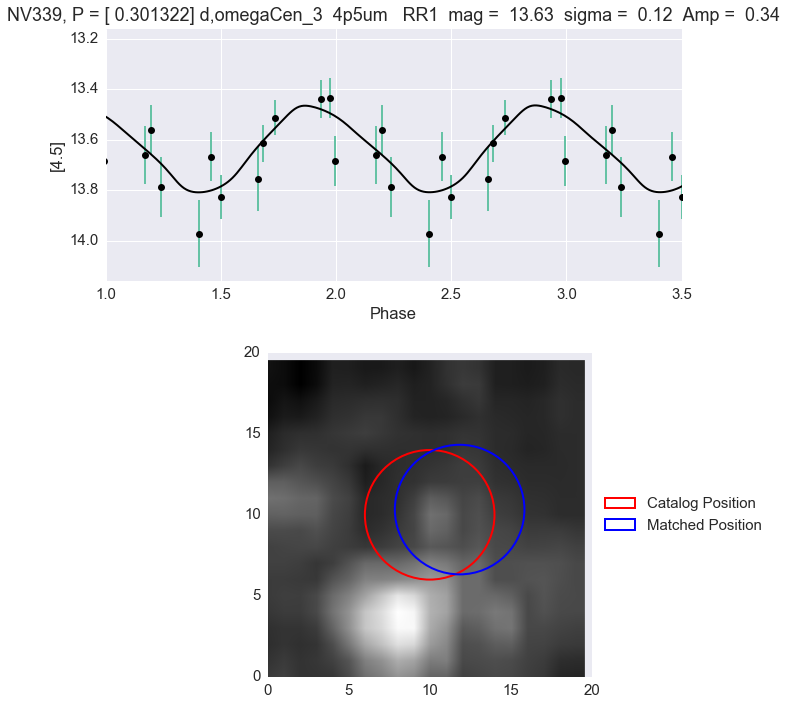

Is this a good star?
Answer yes or no: y


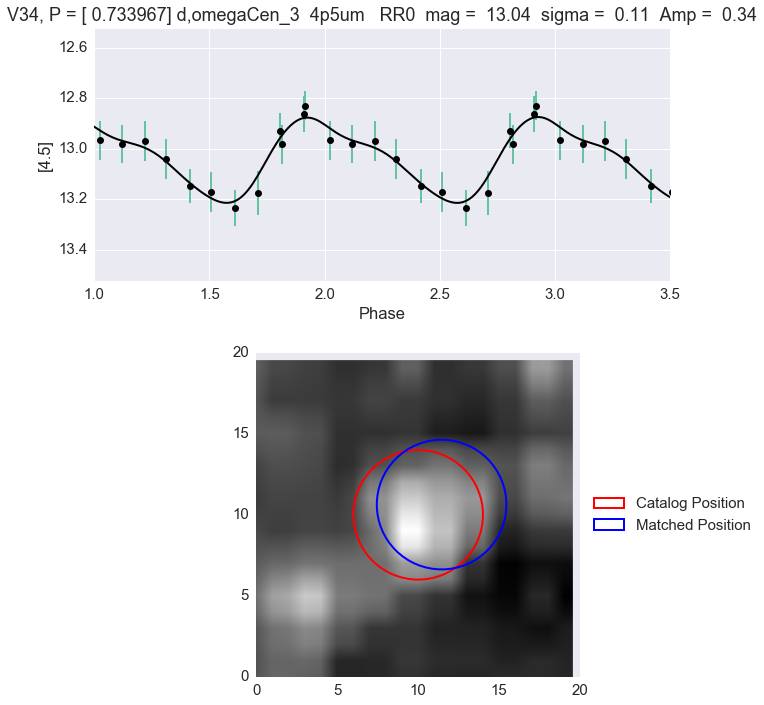

Is this a good star?
Answer yes or no: y


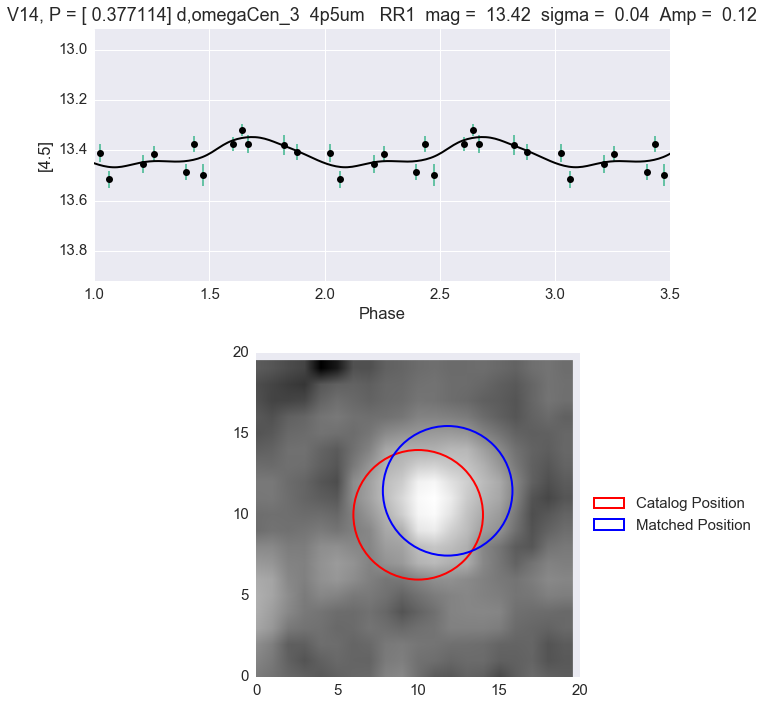

Is this a good star?
Answer yes or no: y


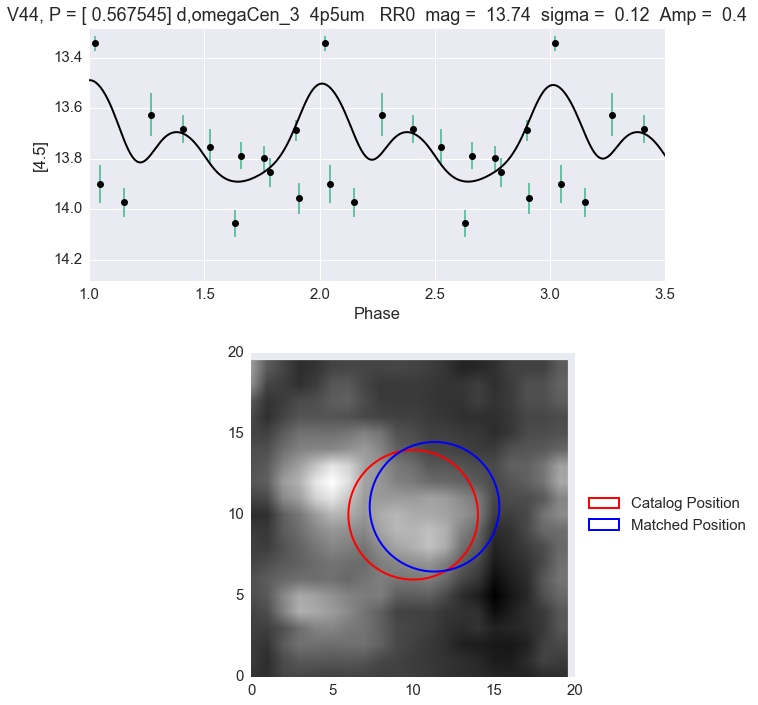

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: c
Clipped discrepant point - refit later


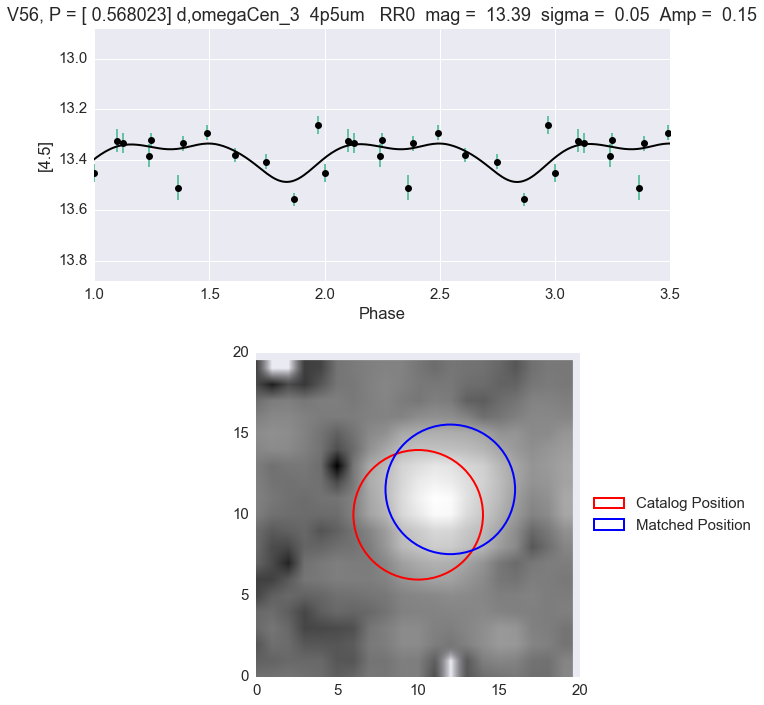

Is this a good star?
Answer yes or no: y


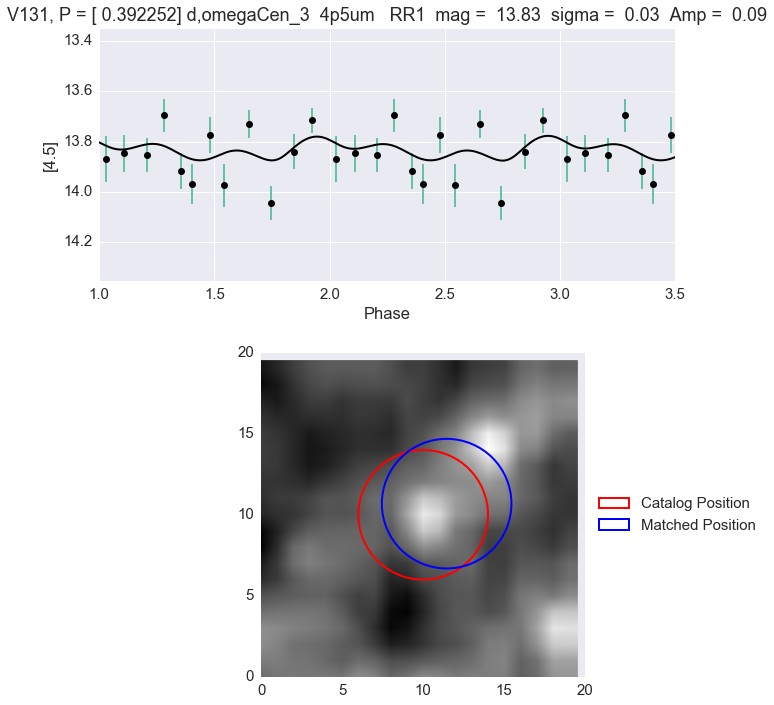

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: r
Rejecting star - setting reject=True, this is reversable


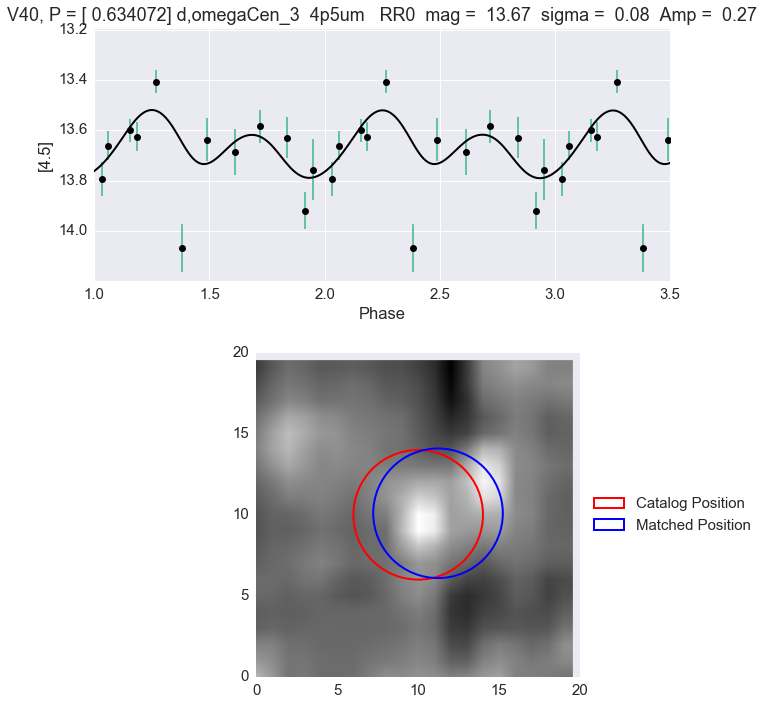

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: c
Clipped discrepant point - refit later


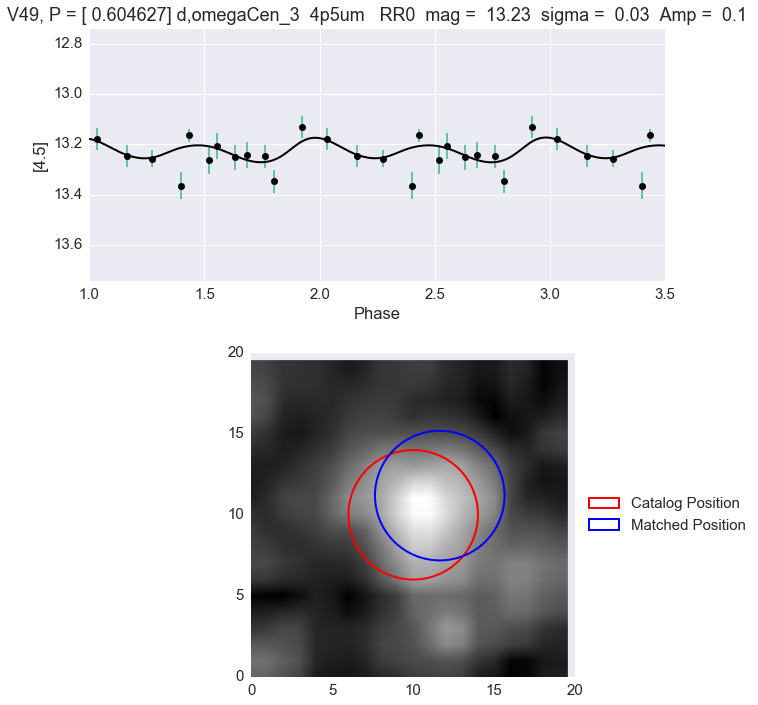

Is this a good star?
Answer yes or no: y


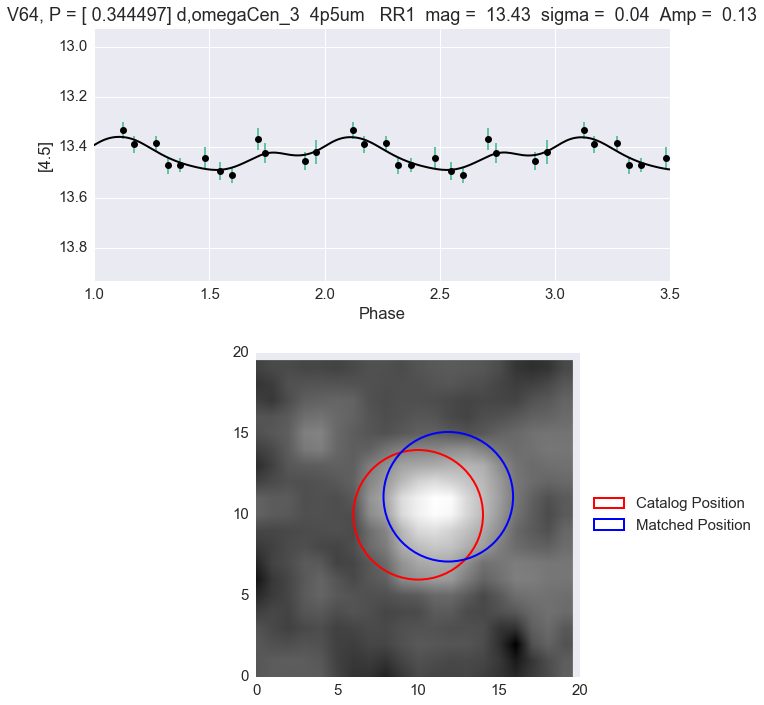

Is this a good star?
Answer yes or no: y


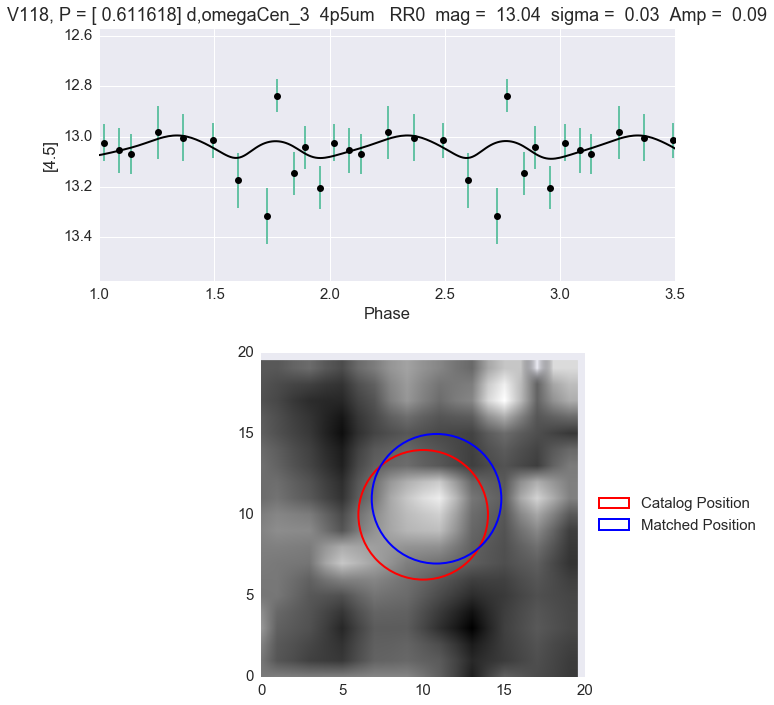

Is this a good star?
Answer yes or no: y


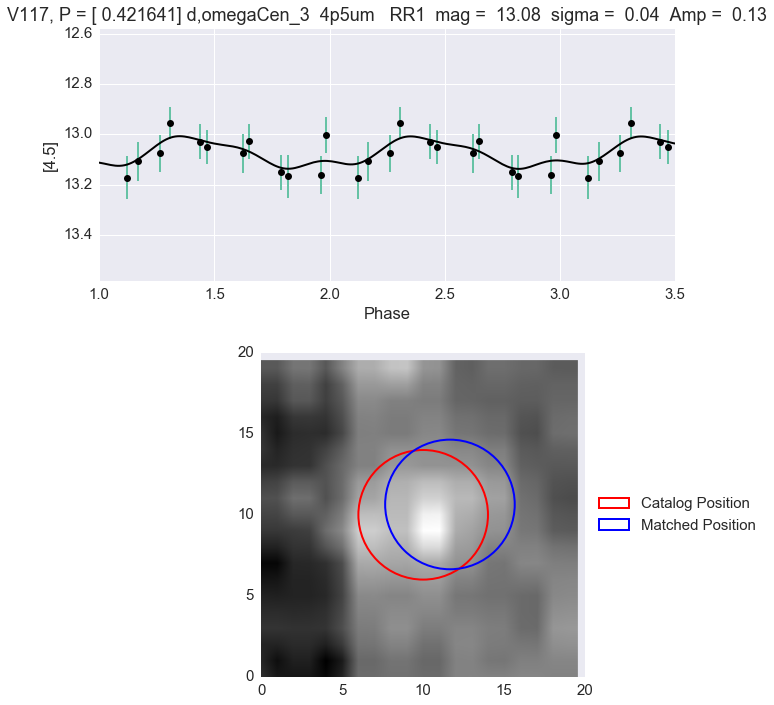

Is this a good star?
Answer yes or no: y


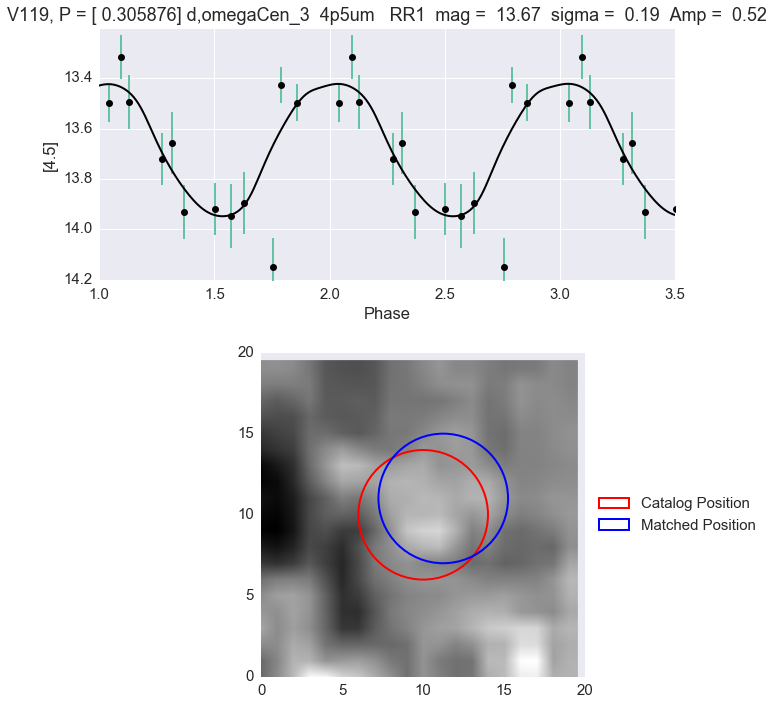

Is this a good star?
Answer yes or no: y


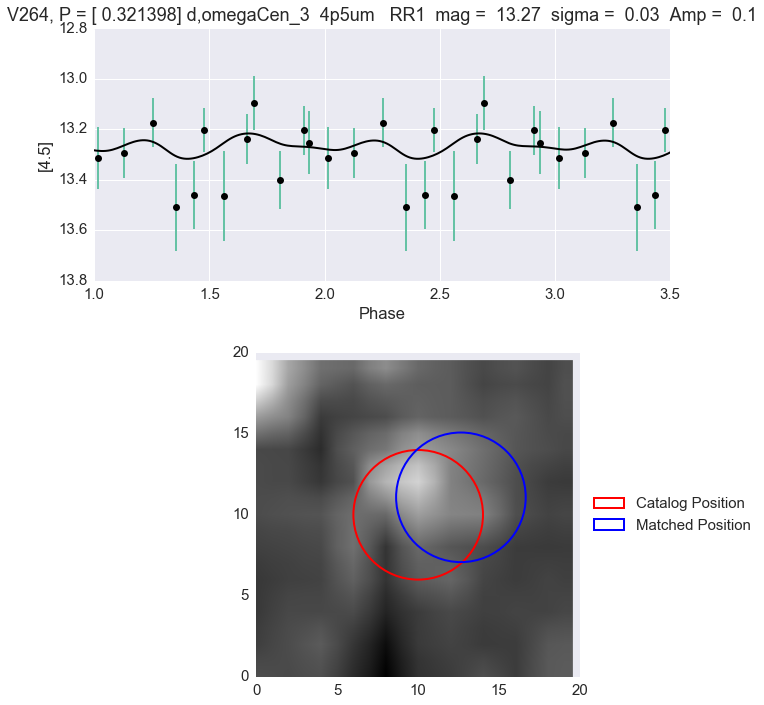

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: r
Rejecting star - setting reject=True, this is reversable


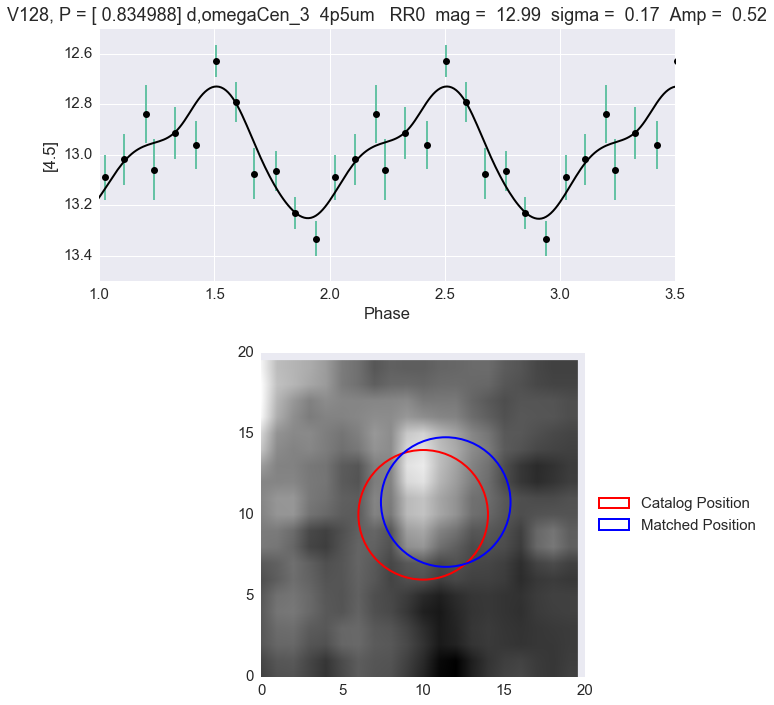

Is this a good star?
Answer yes or no: y


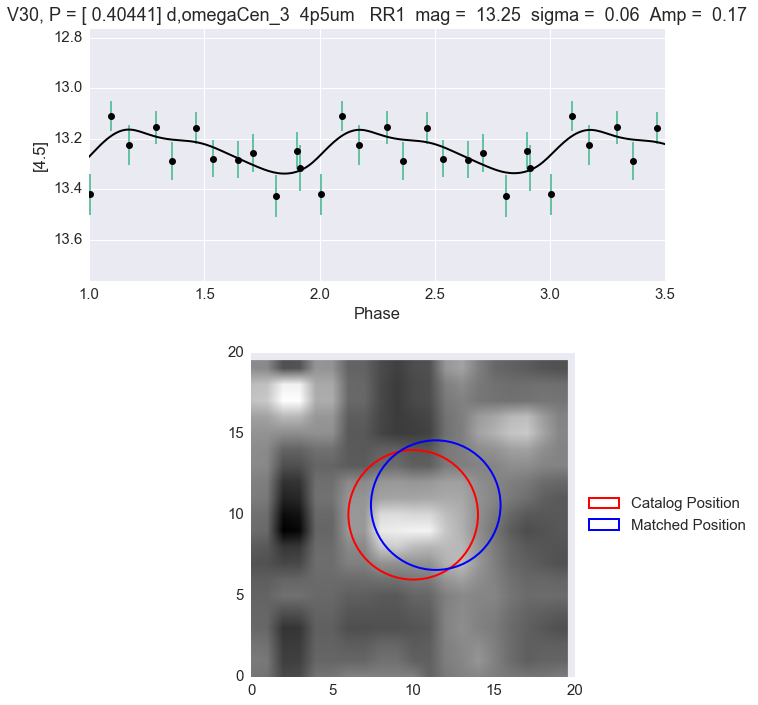

Is this a good star?
Answer yes or no: y


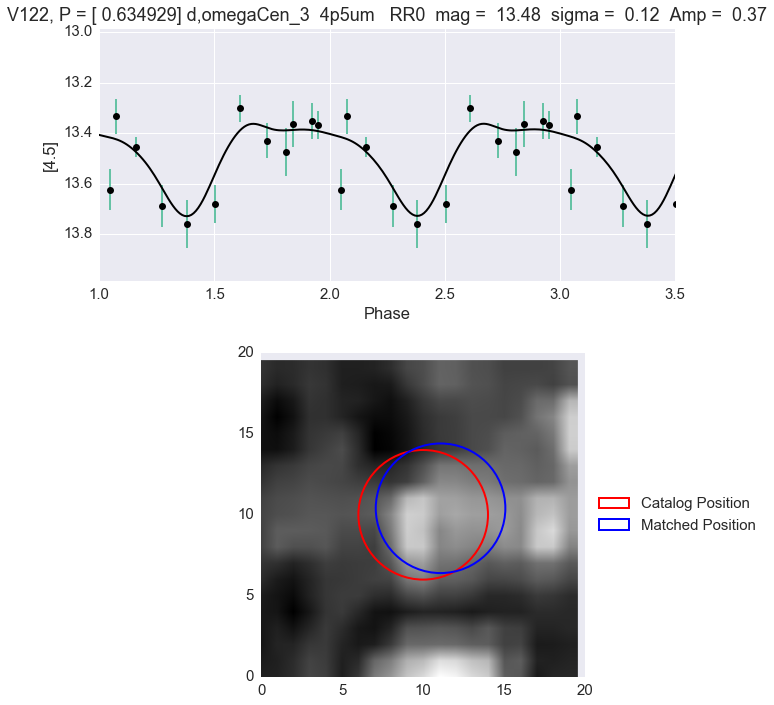

Is this a good star?
Answer yes or no: y


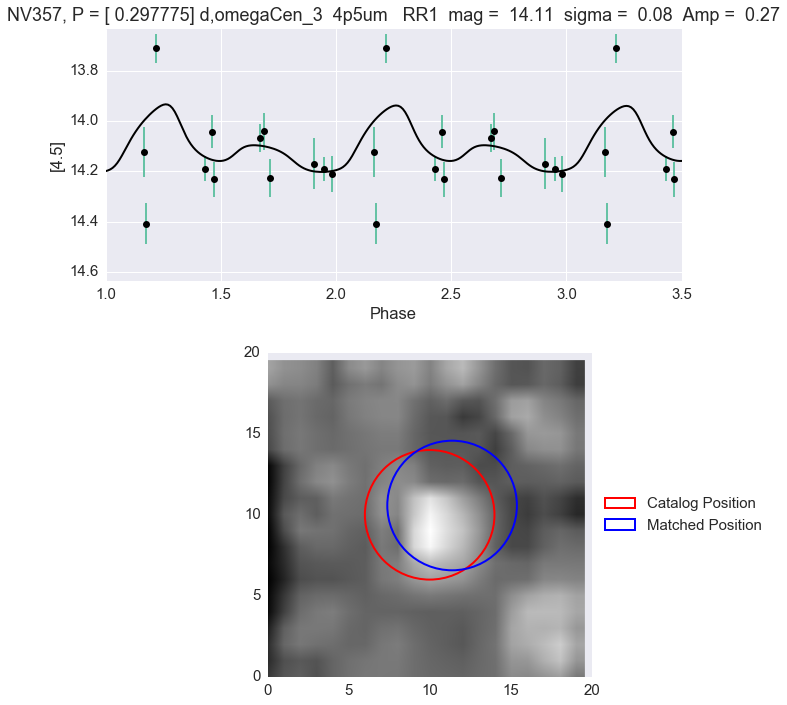

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: c
Clipped discrepant point - refit later


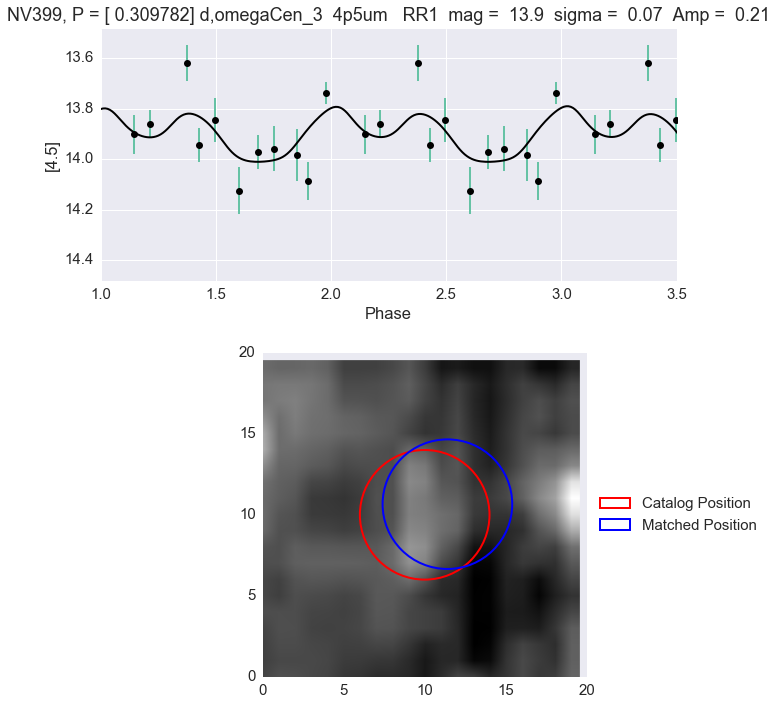

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: r
Rejecting star - setting reject=True, this is reversable


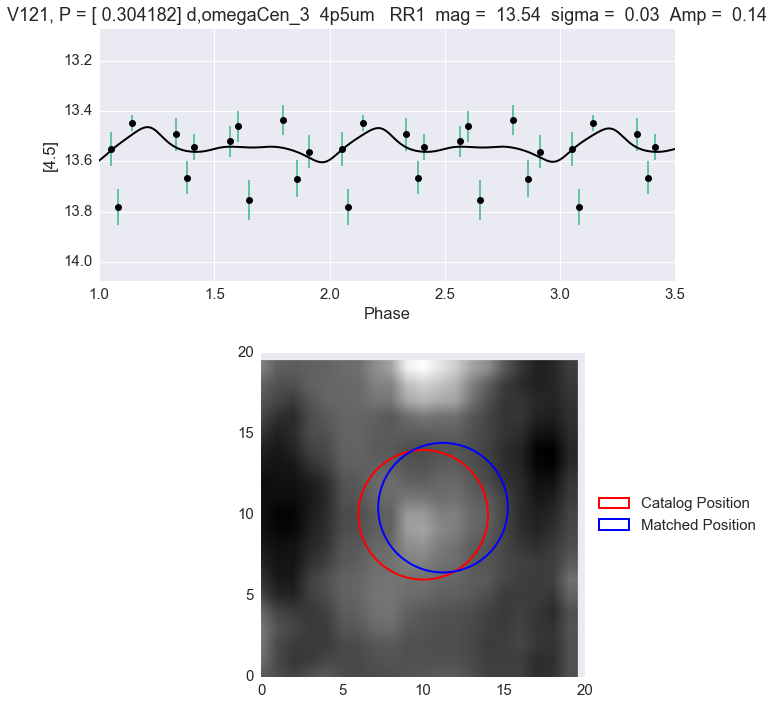

Is this a good star?
Answer yes or no: n
What do you want to do?
Enter "c" to clip the most discrepant point from the light curve
Enter "r" to reject the match as a mis-ID
Enter selection: r
Rejecting star - setting reject=True, this is reversable


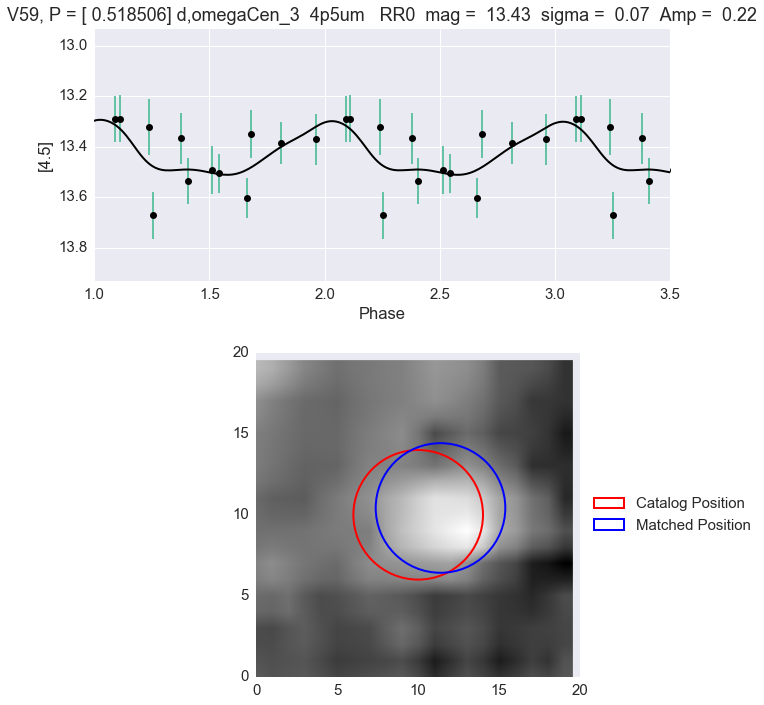

Is this a good star?
Answer yes or no: y


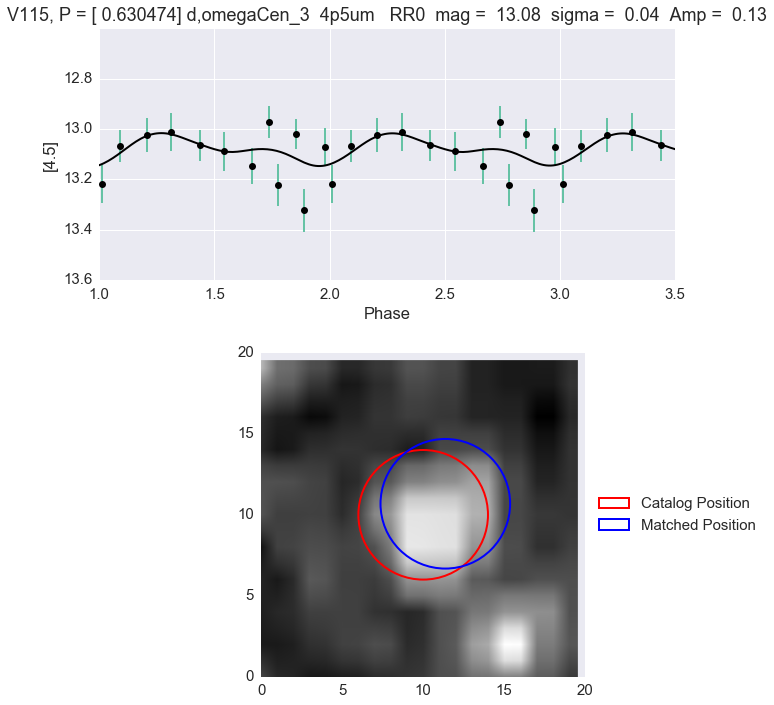

Is this a good star?
Answer yes or no: y


In [465]:
for matched_rrl in np.arange(len(huge_df)):
    kal_id = huge_df.ID[matched_rrl]
    shp = int(mjds.shape[0])
    mag = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    err = huge_df[lc_err_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    period = huge_df.Period.loc[huge_df['ID'] == kal_id].values
    xc = huge_df.xc_ref.loc[huge_df['ID'] == kal_id].values
    yc = huge_df.yc_ref.loc[huge_df['ID'] == kal_id].values
    xc_kal = huge_df.xc_kal.loc[huge_df['ID'] == kal_id].values
    yc_kal = huge_df.yc_kal.loc[huge_df['ID'] == kal_id].values
    Type = huge_df.Type[matched_rrl]


    
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]
    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))
    
    mag_long  = np.concatenate((mag, mag, mag, mag, mag))
    
    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)
    
    mp.close()
    mp.clf()
    
    fig = mp.figure(figsize=(10,10))

    axp1 = fig.add_axes([0.1, 0.6, 0.8, 0.35])


    axp1.axis([1,3.5,(np.average(mag) + 0.5),(np.average(mag) - 0.5)])
    
    smooth = 0.25

    ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(mag_long,err_long,phase,len(mag_long),smooth)
    axp1.plot(ir1x,ir11,'k-')
    aveir1, adevir1, sdevir1, varir1, skewir1, kurtosisir1, ampir1 = gf.moment(ir11[200:300],100)


    axp1.errorbar(phase, mag_long, yerr=err_long, ls='None')
    axp1.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    if (channel == '3p6um'): mp.ylabel('[3.6]')
    if (channel == '4p5um'): mp.ylabel('[4.5]')
    #mp.title(kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + ' x = ' + str(xc) + ' y = ' +  str(yc))
    
    
    size = (20,20)
    position = xc_kal[0], yc_kal[0]
    cutout = Cutout2D(image_data, position, size)
    
    axp2 = fig.add_axes([0.3, 0.05, 0.5, 0.45])
    axp2.imshow(cutout.data, cmap='gray', norm=LogNorm())
    axp2.grid(b=None)
    #axp2.add_artist(Circle(xy=(10, 10), radius=4, edgecolor='red', facecolor='none', linewidth=2, label='Catalog Position'))
    #axp2.add_artist(Circle(xy=((xc-xc_kal)+10, (yc-yc_kal)+10), radius=4, edgecolor='blue', facecolor='none', linewidth=2, label='Matched Position'))
    c = Circle(xy=(10, 10), radius=4, edgecolor='red', facecolor='none', linewidth=2, label='Catalog Position')
    m = Circle(xy=((xc-xc_kal)+10, (yc-yc_kal)+10), radius=4, edgecolor='blue', facecolor='none', linewidth=2, label='Matched Position')
    axp2.add_patch(c)
    axp2.add_patch(m)
    #axp2.plot((xc-xc_kal)+10, (yc-yc_kal)+10, 'o', markersize=20, markeredgewidth=2, markeredgecolor='b', markerfacecolor='None', label='Matched Position')
    mp.xlim(0,20)
    mp.ylim(0,20)
    mp.legend([c, m ], ["Catalog", "Matched"])
    mp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    title_text = (kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + '   '+  Type + '  mag =  ' + str(np.round(aveir1, decimals=2)) + '  sigma =  ' + str(np.round(sdevir1,decimals=2)) + '  Amp =  ' + str(np.round(ampir1,decimals=2)))
    mp.suptitle(title_text)
    
    mp.show()
    
    #print 'Is this star a good match?'
    
    print 'Is this a good star?'
    goodstar = raw_input('Answer yes or no: ')
    if(str.lower(goodstar)=='yes' or str.lower(goodstar)=='y'):
        huge_df.loc[matched_rrl, 'reject'] = False
    elif(str.lower(goodstar)=='no' or str.lower(goodstar)=='n'):
        print 'What do you want to do?'
        print 'Enter "c" to clip the most discrepant point from the light curve'
        print 'Enter "r" to reject the match as a mis-ID'
        selection = raw_input('Enter selection: ')
        if(str.lower(selection)=='c'):
            max_dev = [abs(np.amax(mag_long)-np.mean(mag_long)), abs(np.amin(mag_long)-np.mean(mag_long))]
            most_dev = np.argmax(max_dev)
            if most_dev == 0: bad_index = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].idxmax(axis=1, )
            if most_dev == 1: bad_index = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].idxmin(axis=1, )
            huge_df.loc[huge_df['ID'] == kal_id, bad_index] = np.nan
            huge_df.loc[matched_rrl, 'reject'] = True
            print 'Clipped discrepant point - refit later'
        elif(str.lower(selection)=='r'):
            print 'Rejecting star - setting reject=True, this is reversable'
            huge_df.loc[matched_rrl, 'reject'] = True
        elif(str.lower(selection)=='q'):
            print 'no action taken'
            huge_df.loc[matched_rrl, 'reject'] = False
            continue
        else:
            print 'Rejecting star - setting reject=True, this is reversable'
            huge_df.loc[matched_rrl, 'reject'] = True
    else:
        print 'Is this a good star?'
        goodstar = raw_input('Answer yes or no: ')
          
    mp.close()
    mp.clf()
    

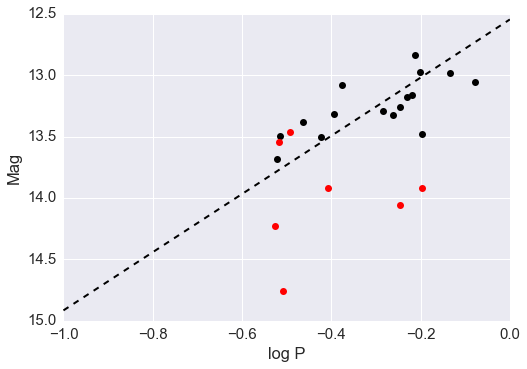

In [466]:

### Doing some quality checks on the matching
mp.close()
mp.clf()
axp1 = mp.subplot(111)

lp1 = np.arange(-1., 1, 1)
def pl1(logp, zp):
    return -2.370 * logp + zp

huge_df['logP'] = np.log10(huge_df.Period)
#huge_df.logP[np.where(huge_df['Type']=='RR1')] = np.log10(huge_df.Period) + 0.127

#huge_df['logP'][np.where(huge_df['Type']=='RR1')] = huge_df['logP'] + 0.127

popt, pcov = curve_fit(pl1,huge_df.logP[huge_df.reject==False],huge_df.mag[huge_df.reject==False])
zp = popt[0]
ezp = np.sqrt(float(pcov[0]))

mp.gca().invert_yaxis()
mp.xlabel('log P')
mp.ylabel('Mag')
#axp1.errorbar(huge_df.logP[huge_df.reject==False], huge_df.mag[huge_df.reject==False], yerr=huge_df.err[huge_df.reject==False], color='k', ls='none')


#axp1.errorbar(huge_df.logP[huge_df.reject==True], huge_df.mag[huge_df.reject==True], yerr=huge_df.err[huge_df.reject==True], color='r', ls='none')


#axp1.errorbar(huge_df.logP[huge_df.reject==True], huge_df.mag[huge_df.reject==True], yerr=huge_df.err[huge_df.reject==True], color='red', ls='none')

axp1.plot(huge_df.logP[huge_df.reject==False], huge_df.mag[huge_df.reject==False], 'ko')

axp1.plot(huge_df.logP[huge_df.reject==True], huge_df.mag[huge_df.reject==True], 'o', color='red')

axp1.plot(lp1, -2.370*lp1 + zp, 'k--')


In [399]:
### define rematch function here:

### cut the input_lc_df around the catalog position, pulling out the data for a few stars, plotting lightcurves for a few stars. get the user to pick the most likely one

#### PICKING THE BEST STAR IS NOT IMPLEMENTED 
#### CAN ONLY ACCEPT OR REJECT THE ORIGINAL BUT IT GIVES MORE INFORMATION THAN THE ORIGINAL PLOTS

#def rematch(ID, xc, yc, xc_kal, yc_kal, mjds, period, shp):
def rematch(row, mjds):
    kal_id = row['ID']
    xc = row['xc_ref']
    yc = row['yc_ref']
    xc_kal = row['xc_kal']
    yc_kal = row['yc_kal']
    period = row['Period']
    shp = int(mjds.shape[0])
    #print xc_kal, yc_kal
    
    search_df = input_lc_df[(input_lc_df.xc>(xc_kal-10))]
    search_df = search_df[(search_df.xc<(xc_kal+10))]
    search_df = search_df[(search_df.yc<(yc_kal+10))]
    search_df = search_df[(search_df.yc>(yc_kal-10))]
    mag = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    err = huge_df[lc_err_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)

    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]
    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))

    orig_lc = np.concatenate((mag, mag, mag, mag, mag))
    orig_err = np.concatenate((err, err, err, err, err))
    
    mean_orig = np.nanmean(orig_lc)
    
    n_stars = len(search_df)
    #print n_stars
    
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
    sns.set_palette("Set2", n_stars)

    palette = itertools.cycle(sns.color_palette())
    starcol = next(palette)
    
    mp.close()
    mp.clf()
    fig = mp.figure(figsize=(10,10))
    
    size = (25,20)
    position = xc_kal, yc_kal
    cutout = Cutout2D(image_data, position, size)
    
    axp1 = fig.add_axes([0.1, 0.6, 0.55, 0.3])
    axp3 = fig.add_axes([0.1, 0.1, 0.55, 0.3])
    
    axp3.plot(huge_df.logP[huge_df.reject==False], huge_df.mag[huge_df.reject==False], 'ko')
    axp3.plot(huge_df.logP[huge_df.reject==True], huge_df.mag[huge_df.reject==True], 'o', color='red')
    axp3.plot(np.log10(period), mean_orig, '*', color=starcol, markersize=30, label='Original match', zorder=4)
    axp3.plot(lp1, -2.370*lp1 + zp, 'k--')
    mp.gca().invert_yaxis()
    mp.xlabel('log P')
    mp.ylabel('Mag')


    smooth = 0.25

    ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(orig_lc[orig_lc>0],orig_err[orig_lc>0],phase[orig_lc>0],len(orig_lc[orig_lc>0]),smooth)
    axp1.plot(ir1x,ir11,'k-')
    o_aveir1, o_adevir1, o_sdevir1, o_varir1, o_skewir1, o_kurtosisir1, o_ampir1 = gf.moment(ir11[200:300],100)
    
    axp1.errorbar(phase, orig_lc, yerr=orig_err, color=starcol, ls='None')
    axp1.plot(phase, orig_lc, 'o', c=starcol, ls='None', label = 'Original match')
    mp.xlabel("Phase")
    if (channel == '3p6um'): mp.ylabel('[3.6]')
    if (channel == '4p5um'): mp.ylabel('[4.5]')
    
    axp2 = fig.add_axes([0.7, 0.6, 0.3, 0.3])
    axp2.imshow(cutout.data, cmap='gray', norm=LogNorm())
    axp2.grid(b=None)
    mp.xlim(0,20)
    mp.ylim(0,20)

    
    c = Circle(xy=(10, 10), radius=4, edgecolor='red', facecolor='none', linewidth=2, label='Catalog Position')
    m = Circle(xy=((xc-xc_kal)+10, (yc-yc_kal)+10), radius=1.0, edgecolor=starcol, facecolor='none', linewidth=2, label='Original Position')
    axp2.add_patch(c)
    axp2.add_patch(m)
    
    axp1.axis([1,3.5,(np.nanmean(mag) + 0.5),(np.nanmean(mag) - 0.5)])

    search_df = search_df.reset_index(drop=True)
    possibles = []
    count = 1
    for lcs in np.arange(len(search_df) - 1):
        
        if(search_df.xc[lcs]!=xc and search_df.yc[lcs]!=yc):
            starcol = next(palette)
            star_id = search_df.als_id[lcs]
            possibles.append(int(star_id))
            x_star = search_df.xc[lcs]
            y_star = search_df.yc[lcs]
            new_mag = search_df[lc_mag_columns].loc[lcs].values.reshape(shp)
            new_err = search_df[lc_err_columns].loc[lcs].values.reshape(shp)
            new_mag = new_mag[idx]
            new_err = new_err[idx]
            temp_phase = []
            temp_phase = (mjds / period) - np.floor(mjds / period)
            temp_phase = np.concatenate((temp_phase,(temp_phase+1.0),(temp_phase+2.0),(temp_phase+3.0),(temp_phase+4.0)))
            temp_lc = np.concatenate((new_mag, new_mag, new_mag, new_mag, new_mag))
            temp_err = np.concatenate((new_err, new_err, new_err, new_err, new_err))
            
            delta_mag = np.nanmean(temp_lc) - mean_orig + (count * 0.1)
            if delta_mag < 0:
                delta_mag_sign = '-'
            else:
                delta_mag_sign = '+'
            name = str(int(star_id)) + delta_mag_sign + str(np.round(abs(delta_mag), decimals=2))
            circ = (Circle(xy=((x_star-xc_kal)+10, (y_star-yc_kal)+10), radius=0.5, edgecolor=starcol, facecolor='none', linewidth=2, label=name))
            axp2.add_patch(circ)

            #print 'als_id:' + star_id + 'delta mag:' + delta_mag
            
            #print len(temp_phase), len(temp_lc), len(temp_err)
            ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(temp_lc[orig_lc>0],temp_err[orig_lc>0],phase[orig_lc>0],len(orig_lc[orig_lc>0]),smooth)
            aveir1, adevir1, sdevir1, varir1, skewir1, kurtosisir1, ampir1 = gf.moment(ir11[200:300],100)
            print 'als_id: mag, err, amp:', star_id, aveir1, sdevir1, ampir1
            axp1.plot(ir1x,ir11- delta_mag,'-', c=starcol)
            axp1.errorbar(temp_phase, temp_lc - delta_mag, yerr=temp_err, color=starcol, ls='None')
            axp1.plot(temp_phase, temp_lc - delta_mag, 'o', c=starcol, ls='None', label=(name))
            #mp.legend(markerscale=1)
            mp.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
            count = count + 1
    title_text = (kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + '   '+  row['Type'] + '  mag =  ' + str(np.round(o_aveir1, decimals=2)) + '  sigma =  ' + str(np.round(o_sdevir1,decimals=2)) + '  Amp =  ' + str(np.round(o_ampir1,decimals=2)))
    mp.suptitle(title_text, fontsize=20)
    mp.show()
    
    print 'Are any of these good stars?'
    goodstar = raw_input('Answer yes or no: ')
    if(str.lower(goodstar)=='yes' or str.lower(goodstar)=='y'):
        print 'Enter "o" for Original match or "a" to enter alternate match ID'
        print 'Otherwise enter "r" to reject all stars'
        selection = raw_input('Enter selection: ')
        if (str.lower(selection)=='o'):
            huge_df.ix[huge_df.ID==kal_id, 'reject'] = False
            return('original')
        elif(str.lower(selection)=='r'):
            return('rejected')
        elif(str.lower(selection)=='a'):
            print "Possible Alternate IDs:"
            print possibles
            alt_id = raw_input('Enter ID number of alternate match: ')
            if(alt_id in possibles):
                good_df = search_df[search_df.als_id==alt_id]
                huge_df.ix[huge_df.ID==kal_id, 'Rematch'] = alt_id
                #huge_df.ix[huge_df.ID==kal_id, 'als_id'] = alt_id
                #huge_df.ix[huge_df.ID==kal_id, 'xc_lc'] = good_df.xc.values
                #huge_df.ix[huge_df.ID==kal_id, 'yc_lc'] = good_df.yc.values
                #huge_df.ix[huge_df.ID==kal_id, lc_mag_columns] = good_df[lc_mag_columns]
                #huge_df.ix[huge_df.ID==kal_id, lc_err_columns] = good_df[lc_err_columns]
                #huge_df.ix[huge_df.ID==kal_id, 'reject'] = False
                return('accepted new')
            else:
                print 'Rejecting all stars'
                return('reject')

    if(str.lower(goodstar)=='no' or str.lower(goodstar)=='n'):
        print 'Rejecting all stars'
        return('reject')
    

            
 
    

als_id: mag, err, amp: 10234.0 16.8637875407 0.262028546916 0.809336192588
als_id: mag, err, amp: 10301.0 16.4200778863 0.290305690174 1.05889080592
als_id: mag, err, amp: 10332.0 13.8161924884 0.0740514497143 0.255978542056
als_id: mag, err, amp: 10182.0 13.576393139 0.0749511484345 0.268040674258


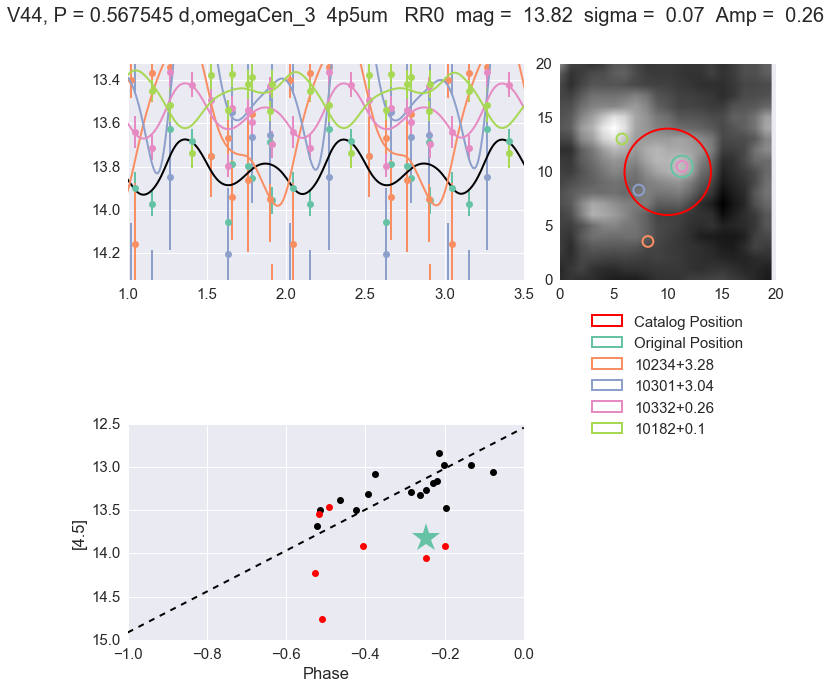

Are any of these good stars?
Answer yes or no: n
Rejecting all stars
als_id: mag, err, amp: 1716.0 15.1991088477 0.147041049277 0.440520371933
als_id: mag, err, amp: 1932.0 13.8341547362 0.0273149291011 0.0943583730147
als_id: mag, err, amp: 1988.0 13.5569810422 0.0656903113181 0.221167810154


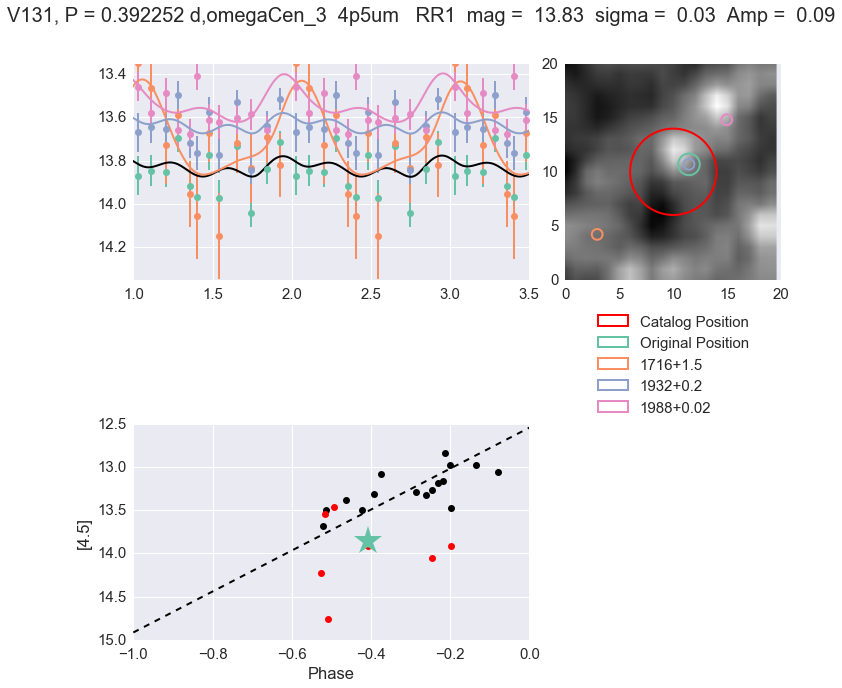

Are any of these good stars?
Answer yes or no: n
Rejecting all stars
als_id: mag, err, amp: 4247.0 14.4669730653 0.057504082771 0.188381485183
als_id: mag, err, amp: 4470.0 15.8593334349 0.0991994597971 0.297464678637
als_id: mag, err, amp: 4338.0 15.6742625086 0.0352544837159 0.126220963543
als_id: mag, err, amp: 4485.0 13.624687681 0.107360515198 0.356642544012
als_id: mag, err, amp: 4372.0 14.6382163354 0.133755118931 0.484334056079
als_id: mag, err, amp: 4528.0 13.7113032935 0.0347655667489 0.119232510959
als_id: mag, err, amp: 4307.0 14.0229299836 0.0454569375491 0.145369812839


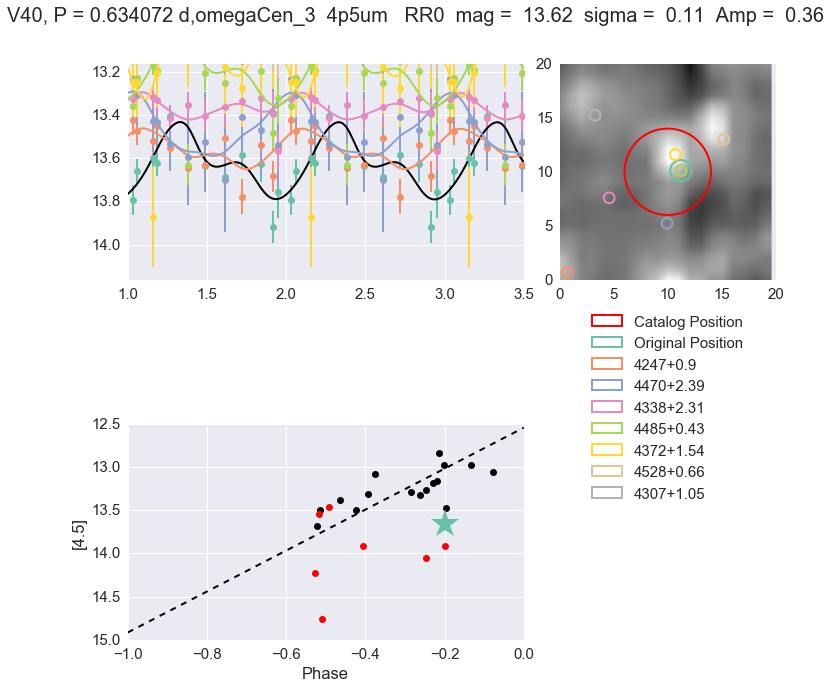

Are any of these good stars?
Answer yes or no: n
Rejecting all stars
als_id: mag, err, amp: 878.0 14.6871549717 0.0329590825656 0.108214035207
als_id: mag, err, amp: 808.0 13.7675328536 0.0613407340591 0.190231207584
als_id: mag, err, amp: 881.0 13.265549824 0.0275530954896 0.100554006767
als_id: mag, err, amp: 844.0 11.7805914106 0.0348433581058 0.123262907626


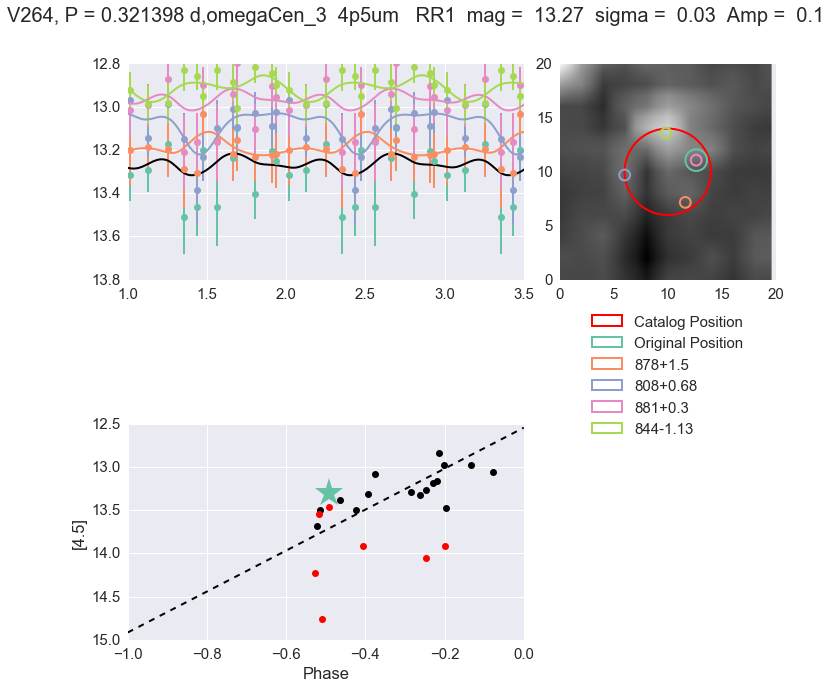

Are any of these good stars?
Answer yes or no: y
Enter "o" for Original match or "a" to enter alternate match ID
Otherwise enter "r" to reject all stars
Enter selection: a
Possible Alternate IDs:
[878, 808, 881, 844]
Enter ID number of alternate match: 808
Rejecting all stars
als_id: mag, err, amp: 5604.0 14.7057475853 0.112329412508 0.348315103987
als_id: mag, err, amp: 5476.0 16.3807392555 0.262214581051 0.770799497101
als_id: mag, err, amp: 5423.0 14.1847822583 0.0675564954499 0.20193818372


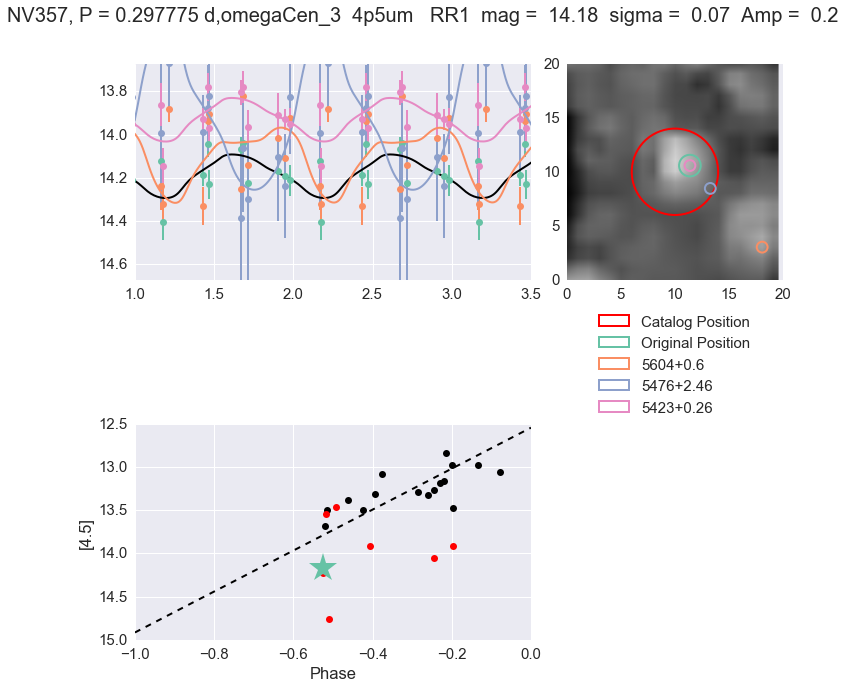

Are any of these good stars?
Answer yes or no: n
Rejecting all stars
als_id: mag, err, amp: 2406.0 14.7942320358 0.105120740942 0.347101689635
als_id: mag, err, amp: 2513.0 14.842194015 0.159924172459 0.492684205443
als_id: mag, err, amp: 2268.0 15.2444462595 0.0809204635021 0.261431016272
als_id: mag, err, amp: 2519.0 13.9017053905 0.069166287391 0.213195290351
als_id: mag, err, amp: 2514.0 14.6106215141 0.168236872782 0.543140150738


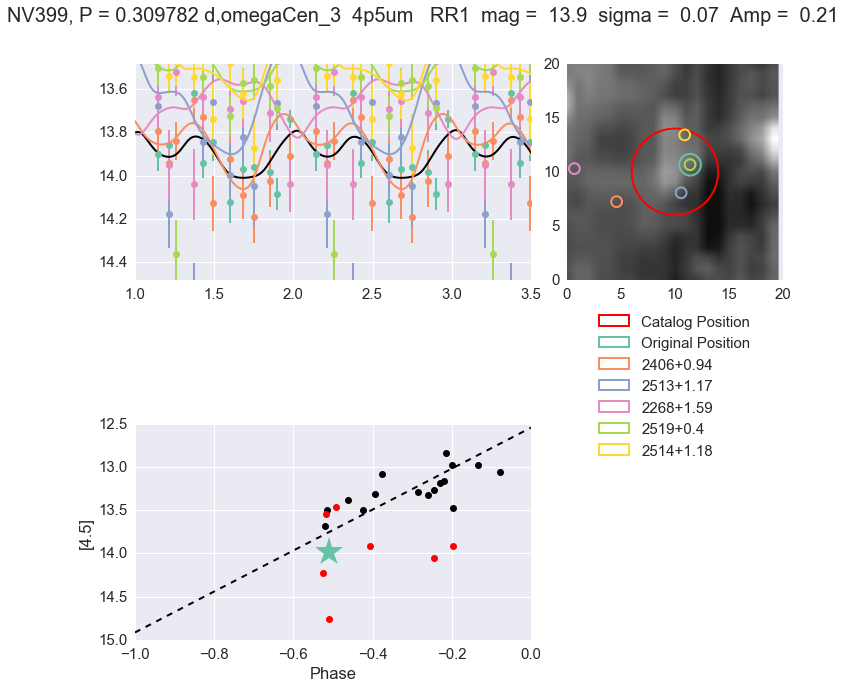

Are any of these good stars?
Answer yes or no: n
Rejecting all stars
als_id: mag, err, amp: 5071.0 15.7559575523 0.0398534309019 0.116228017628
als_id: mag, err, amp: 4978.0 14.9492655672 0.0233246427807 0.0791137027451
als_id: mag, err, amp: 5009.0 13.5428291157 0.0334141726007 0.13959170465


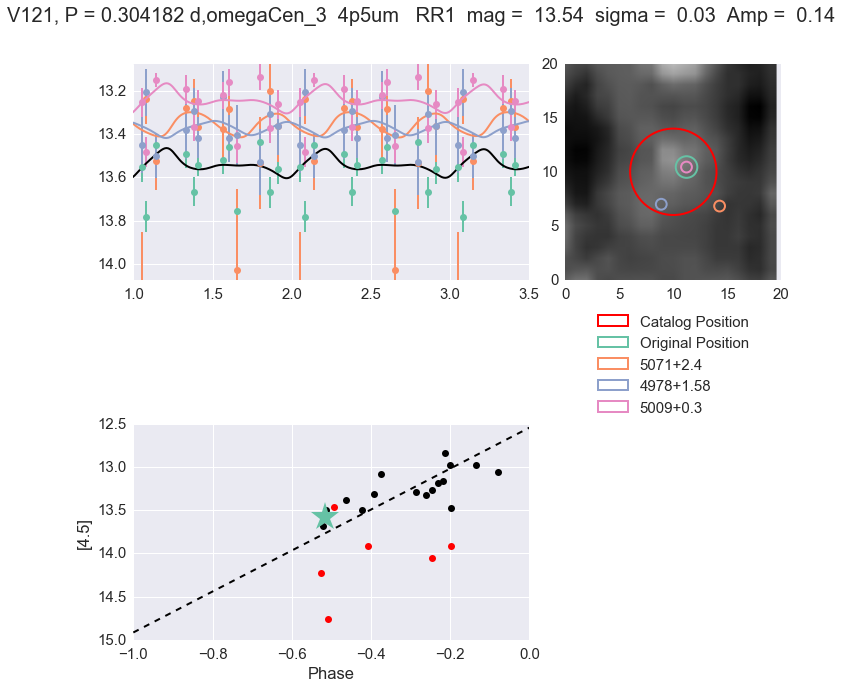

Are any of these good stars?
Answer yes or no: n
Rejecting all stars


5     reject
7     reject
8     reject
14    reject
18    reject
19    reject
20    reject
dtype: object

In [467]:
huge_df[huge_df.reject==True].apply(lambda line: rematch(line, mjds), axis=1)

In [468]:
len(huge_df[huge_df.reject==False])

16

In [469]:
outfile_cut = input_target + '_' + channel + '_rrl' + '_matched_to_kaluzny.cut'


In [275]:
#huge_df[huge_df.reject==False].to_csv(outfile_cut, sep='\t', header=True, index=False)

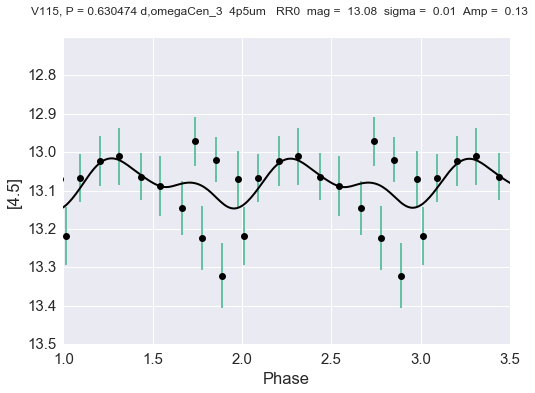

In [470]:
good_rrl_df = huge_df[huge_df.reject==False]
good_rrl_df = good_rrl_df.reset_index(drop=True)
good_rrl_df['Gloess_mag'] = np.nan
good_rrl_df['Gloess_err'] = np.nan
good_rrl_df['Gloess_amp'] = np.nan

for rrl in np.arange(len(good_rrl_df)):
    kal_id = good_rrl_df.ID[rrl]
    shp = int(mjds.shape[0])
    mag = good_rrl_df[lc_mag_columns].loc[good_rrl_df['ID'] == kal_id].values.reshape(shp)
    err = good_rrl_df[lc_err_columns].loc[good_rrl_df['ID'] == kal_id].values.reshape(shp)
    period = good_rrl_df.Period.loc[good_rrl_df['ID'] == kal_id].values[0]
    xc = good_rrl_df.xc_ref.loc[good_rrl_df['ID'] == kal_id].values[0]
    yc = good_rrl_df.yc_ref.loc[good_rrl_df['ID'] == kal_id].values[0]
    Type = good_rrl_df.Type[rrl]
 
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]
    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))
    
    mag_long  = np.concatenate((mag, mag, mag, mag, mag))
    
    err_long = np.concatenate((err, err, err, err, err))
    
    smooth = 0.25
    mp.close()
    mp.clf()
    axp1 = mp.subplot(111)

    axp1.axis([1,3.5,(np.nanmean(mag) + 0.4),(np.nanmean(mag) - 0.4)])
    ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(mag_long[mag_long>0],err_long[mag_long>0],phase[mag_long>0],len(mag_long[mag_long>0]),smooth)
    axp1.plot(ir1x,ir11,'k-')
    aveir1, adevir1, sdevir1, varir1, skewir1, kurtosisir1, ampir1 = gf.moment(ir11[200:300],100)
    good_rrl_df.loc[good_rrl_df['ID'] == kal_id, 'Gloess_mag'] = aveir1
    good_rrl_df.loc[good_rrl_df['ID'] == kal_id, 'Gloess_err'] = sdevir1/np.sqrt(len(mag>0))
    good_rrl_df.loc[good_rrl_df['ID'] == kal_id, 'Gloess_amp'] = ampir1



    output = str(kal_id) + '_rrlyrae.data'
    output_file = open(new_dir + '/' + output, "w")

    for frame in np.arange(0, num_frames):
        output_file.write("{0:.8f} {1:.3f} {2:.3f} \n".format(mjds[frame], mag[frame], err[frame]))
    
    output_file.close()
    ## Sanity check plot

    axp1.errorbar(phase, mag_long, yerr=err_long, ls='None')
    axp1.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    if (channel == '3p6um'): mp.ylabel('[3.6]')
    if (channel == '4p5um'): mp.ylabel('[4.5]')
    title_text = (kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + '   '+  Type + '  mag =  ' + str(np.round(aveir1, decimals=2)) + '  sigma =  ' + str(np.round(sdevir1/np.sqrt(len(mag>0)),decimals=2)) + '  Amp =  ' + str(np.round(ampir1,decimals=2)))
    mp.suptitle(title_text, fontsize=12)    #mp.show()

    mp.savefig(new_dir + '/' + str(kal_id) + '_F' + field + '_' + channel +'.pdf')

    #mp.show()
   

In [472]:
good_rrl_df.to_csv(outfile_cut, sep='\t', header=True, index=False)

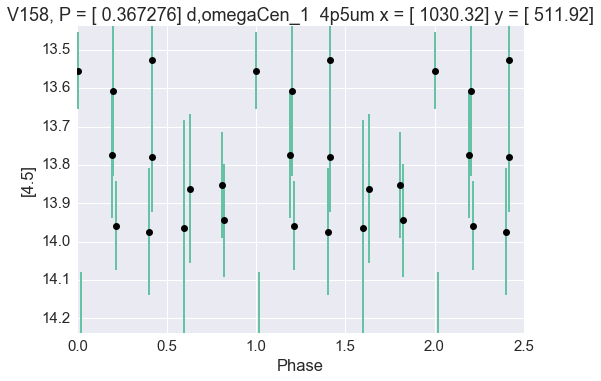

In [322]:
for rrl in np.arange(len(huge_df)):
    kal_id = huge_df.ID[rrl]
    shp = int(mjds.shape[0])
    mag = huge_df[lc_mag_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    err = huge_df[lc_err_columns].loc[huge_df['ID'] == kal_id].values.reshape(shp)
    period = huge_df.Period.loc[huge_df['ID'] == kal_id].values
    xc = huge_df.xc_ref.loc[huge_df['ID'] == kal_id].values
    yc = huge_df.yc_ref.loc[huge_df['ID'] == kal_id].values
 
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]
    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))
    
    mag_long  = np.concatenate((mag, mag, mag, mag, mag))
    
    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)

    #output = str(kal_id) + '_rrlyrae.data'
    output_file = open(new_dir + '/' + output, "w")

    for frame in np.arange(0, num_frames):
        output_file.write("{0:.8f} {1:.3f} {2:.3f} \n".format(mjds[frame], mag[frame], err[frame]))
    
    output_file.close()
    ## Sanity check plot

    mp.close()
    mp.clf()
    axp1 = mp.subplot(111)

    axp1.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])

    axp1.errorbar(phase, mag_long, yerr=err_long, ls='None')
    axp1.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    if (channel == '3p6um'): mp.ylabel('[3.6]')
    if (channel == '4p5um'): mp.ylabel('[4.5]')
    mp.title(kal_id + ', P = ' + str(period) +' d,' + input_target + '  ' + channel + ' x = ' + str(xc) + ' y = ' +  str(yc))
    #mp.show()

    #mp.savefig(new_dir + '/' + str(kal_id) + '_F' + field + '_' + channel +'.pdf')

    #mp.close()
   